In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

In [2]:
%run ./FNO.py
%run ./Data_Generator/KFRDG.ipynb

In [3]:
%run ./SaveFig.ipynb

# Solve Equation with FNO

In [ ]:
def Analyze(Param):
    %run ./FNO.py
    %run ./Data_Generator/KFRDG.ipynb
    
    %run ./SaveFig.ipynb
    Alpha = Param["Alpha"]
    InitialSolve = Param["InitialSolve"]
    Ndt = Param["Ndt"]
    TrainingSamples = Param["TrainingSamples"]
    FinalSolve = Param["FinalSolve"]
    S = Param["S"]

    Initial = Param["Initial"]
    Cutoff = Param["Cutoff"]
    
    Path_U_IS = 'Data_Generator/' + f'u_original_{Alpha}_{InitialSolve}.npy' 
    
    U_InitialSolve = torch.tensor(np.load(Path_U_IS, allow_pickle=True))
    
    model = torch.load(f'KFR_FNO_skiptype{Ndt}_alpha{Alpha}_trainingsamples{TrainingSamples}')
    
    U_Theoretical = DataGenerator_Alpha(Alpha, TrainingSamples, Ndt, FinalSolve)
    
    U_Gt = U_Theoretical['u_original']
    Time = U_Theoretical['time'][-1]
    
    L = 6
    N = 200
    dx = L / N  # grid size

    x = np.empty(N + 7)
    x[0:3] = [(-L + dx * i) for i in [-3, -2, -1]]  # left ghost points
    x[3:N + 4] = [(-L + dx * i) for i in range(N + 1)]  # internal grid points on [-L,0]
    x[N + 4:N + 7] = np.arange(1, 4) * dx  # grid points ahead of the shock

    Length=np.array([x])[-1]
    
    EndForTime = (Time[::Ndt].shape[-1]-U_InitialSolve[::Ndt,-1].shape[-1])-1
    
    #####
    #Main Loop
    #####
    time = []
    w = model(U_InitialSolve[-1,:].float().reshape(1,S,1).cuda())
    time.append(w.cpu().detach().numpy()) 
    for i in range(0,EndForTime):
        with torch.no_grad():
            w = model(w)
        time.append(w.cpu().detach().numpy())

    timenp = np.array(time)

    time_shock = timenp[:,-1,:,-1]
    time_pde = timenp[:,-1,:,:]
    
    Inf, L2 = FigureSave(Time,Length,U_Gt,U_InitialSolve,time_pde,time_shock,Ndt,Initial,Cutoff,Alpha)
    
    return Inf, L2

In [5]:
################################################################
#  configurations for Data Generation for Analysis
################################################################

Alpha = 4.85
InitialSolve = 350
Ndt = 20
TrainingSamples = 1500
FinalSolve = 10000
S = 207

Initial = 9500
Cutoff = 10000

In [6]:
Path_U_IS = 'Data_Generator/' + f'u_original_{Alpha}_{InitialSolve}.npy' 

In [7]:
U_InitialSolve = torch.tensor(np.load(Path_U_IS, allow_pickle=True))

In [13]:
model = torch.load(f'KFR_FNO_skiptype{Ndt}_alpha{Alpha}_trainingsamples{TrainingSamples}')

In [157]:
U_Theoretical = DataGenerator_Alpha(Alpha, TrainingSamples, Ndt, FinalSolve)

amp_0alpha_4.85 =-=-=-=-=-= 641.49s
Completed


# Comparison

In [281]:
model = torch.load(f'KFR_FNO_skiptype{Ndt}_alpha{Alpha}_trainingsamples{TrainingSamples}')

In [282]:
U_Gt = U_Theoretical['u_original']
Time = U_Theoretical['time'][-1]

In [392]:
Time[::Ndt].shape[-1]

10564

In [8]:
L = 6
N = 200
dx = L / N  # grid size

x = np.empty(N + 7)
x[0:3] = [(-L + dx * i) for i in [-3, -2, -1]]  # left ghost points
x[3:N + 4] = [(-L + dx * i) for i in range(N + 1)]  # internal grid points on [-L,0]
x[N + 4:N + 7] = np.arange(1, 4) * dx  # grid points ahead of the shock

Length=np.array([x])[-1]

In [387]:
EndForTime = (Time[::Ndt].shape[-1]-U_InitialSolve[::Ndt,-1].shape[-1])-1

In [405]:
dt=Time[1]-Time[0]

In [440]:
Ti = 100000

In [441]:
ed = round((Ti-350)/(20*dt))

In [442]:
time = []
start_timer = default_timer()
w = model(U_InitialSolve[-1,:].float().reshape(1,S,1).cuda())
time.append(w.cpu().detach().numpy()) 
for i in range(0,ed):
    with torch.no_grad():
        w = model(w)
    time.append(w.cpu().detach().numpy())
end_timer = default_timer()
print("Time for Evaluation: ", end_timer - start_timer)
    
timenp = np.array(time)

time_shock = timenp[:,-1,:,-1]
time_pde = timenp[:,-1,:,:]

Time for Evaluation:  248.5151943024248


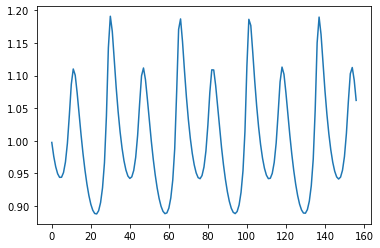

In [415]:
plt.plot(time_shock[:,-1])

Text(0, 0.5, 't')

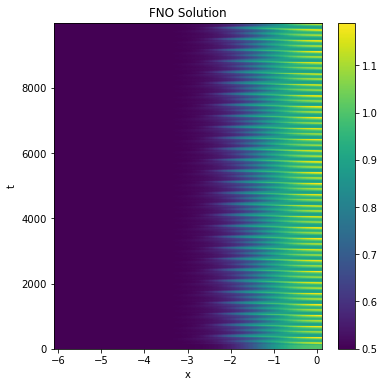

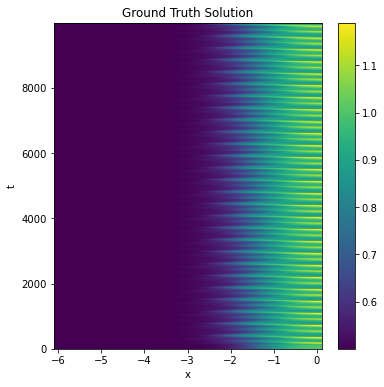

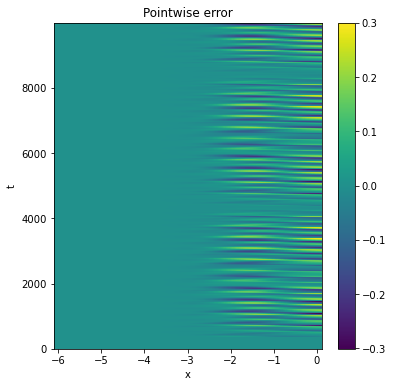

In [294]:
U_PDE_FNO = np.append(U_InitialSolve[0:-1:20,:],time_pde[:,:]).reshape(-1,207)
fig = figure(figsize=(6, 6))
X, T = np.meshgrid(Length,Time[::Ndt])            
plt.pcolormesh(X,T,U_PDE_FNO)
plt.colorbar()
plt.title("FNO Solution")
plt.xlabel('x')
plt.ylabel('t')
#plt.savefig("Figures/" + f'PDEFNO_{Alpha}_{Ndt}.jpg')            

fig = figure(figsize=(6, 6))
plt.pcolormesh(X,T,U_Gt[::Ndt,:])
plt.colorbar()
plt.title("Ground Truth Solution")
plt.xlabel('x')
plt.ylabel('t')
#plt.savefig("Figures/" + f'PDEGT_{Alpha}.jpg')

fig = figure(figsize=(6, 6))    
error_PDE = U_PDE_FNO - U_Gt[::Ndt,:]
plt.pcolormesh(X,T,error_PDE)
plt.colorbar()
plt.title("Pointwise error")
plt.xlabel('x')
plt.ylabel('t')
#plt.savefig("Figures/" + f'PDEerror_{Alpha}_{Ndt}.jpg')

In [9]:
time = np.load('Data_Generator/time_4.85_350.npy', allow_pickle=True)

In [11]:
X, T = np.meshgrid(Length,time) 

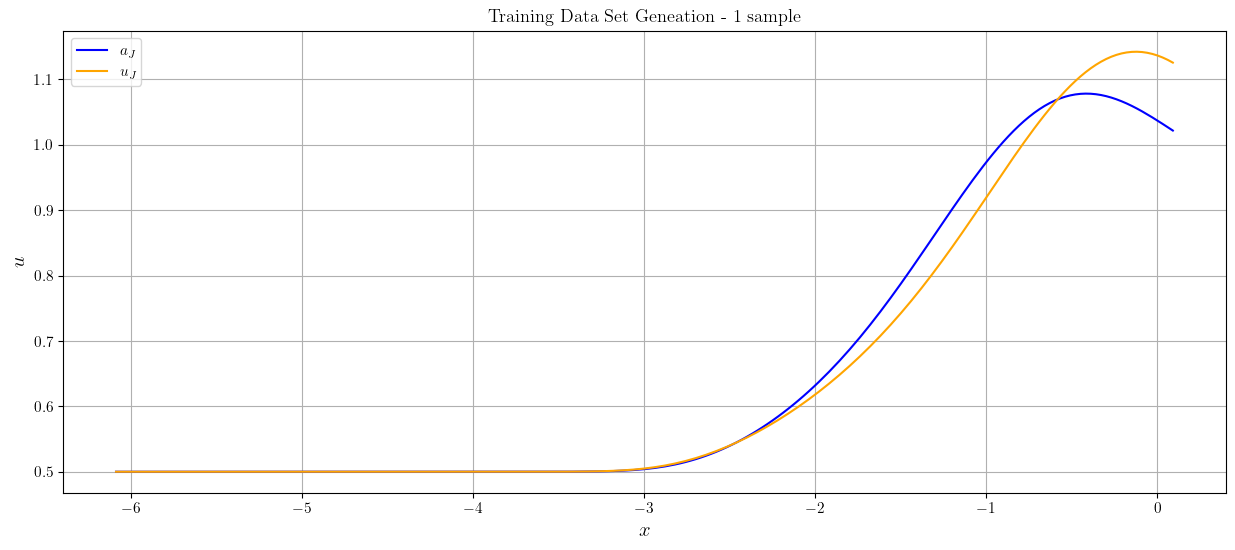

In [20]:
from matplotlib.font_manager import FontProperties

fig = figure(figsize=(15, 6))
plt.plot(x,U_InitialSolve[6520,:],'blue')
plt.plot(x,U_InitialSolve[6540,:],'orange')
plt.title("Training Data Set Geneation - $1$ sample")
font = FontProperties()
font.set_name('Times New Roman')
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$u$',fontsize=15)
plt.legend([r'$a_J$',r'$u_J$'])
# plt.plot(5000,U_InitialSolve[5000,-1],'x')
# plt.plot(5020,U_InitialSolve[5020,-1],'o')

# plt.plot(5700,U_InitialSolve[5700,-1],'x')
# plt.plot(5720,U_InitialSolve[5720,-1],'o')

# plt.plot(6480,U_InitialSolve[6480,-1],'x')
# plt.plot(6500,U_InitialSolve[6500,-1],'o')

# plt.plot(6520,U_InitialSolve[6520,-1],'x')
# plt.plot(6540,U_InitialSolve[6540,-1],'o')

# plt.plot(5770,U_InitialSolve[5770,-1],'x')
# plt.plot(5790,U_InitialSolve[5790,-1],'o')

# plt.plot(5980,U_InitialSolve[5980,-1],'x')
# plt.plot(6000,U_InitialSolve[6000,-1],'o')

#plt.xlim([5000,7000])
plt.grid(True)
plt.savefig('Figures/TD7.jpg')
plt.show()

In [22]:
fig = figure(figsize=(15, 6))
plt.plot(U_InitialSolve[:,-1],'grey')
plt.title("Initially solved equation")
font = FontProperties()
font.set_name('Times New Roman')
plt.xlabel('Size of Time Array',fontsize=13)
plt.ylabel(r'$u_s$',fontsize=13)



plt.plot(6520,U_InitialSolve[6520,-1],'x')
plt.plot(6540,U_InitialSolve[6540,-1],'o')
plt.legend([r'$u_s$',r'$a_J$',r'$u_J$'])
plt.xlim([5000,7600])
plt.grid(True)
#plt.show()

plt.savefig('Figures/ISE_TD.jpg')

In [35]:
time[-1][6540]

311.6374535100755

In [358]:
time[-1][1]-time[-1][0]

0.04787225223001257